In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.neural_network import MLPRegressor
from joblib import dump
%matplotlib inline
from sklearn.metrics import mean_squared_error
np.random.seed(42)
from sklearn import neighbors
from math import sqrt

In [2]:
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive')
gdrive_path = os.getcwd()

Mounted at /content/drive


In [3]:
path = Path.cwd() / "FOM_MA" / "Autos" / "date" / "Automobile_data_4000.csv"

In [14]:
## Data understanding
df = pd.read_csv(path)

In [15]:

## Data preparation
df_amount_0 = df[ df['price'] == 0 ] 

df = df.drop(df_amount_0.index, axis=0) 

df = df.replace('?', np.nan)
df = df.dropna()

df.reset_index() 
df.index =range(len(df))

#deleting the columns 'Row_ID','Household_ID' from the dataframe as it is a unique and does not have any effect on the algorithm
del df['symboling']
del df['normalized-losses']


In [16]:
df.sample(10)

,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
1439,mitsubishi,gas,turbo,four,sedan,rwd,front,109.099998,187.800003,68.400002,55.500000,3054,ohc,four,141,mpfi,3.793224,3.110000,8.700000,159.101700,5400.000000,19,25,21697.658203
3101,peugot,gas,turbo,two,hatchback,rwd,front,100.338783,176.199997,67.798309,51.932194,3047,ohcv,six,156,mpfi,3.310000,3.511250,8.700000,152.217148,4800.000000,22,25,16746.634766
3871,mazda,gas,std,four,sedan,rwd,front,107.980232,188.800003,67.199997,55.700001,2911,ohc,six,152,mpfi,3.620000,3.150000,9.000000,116.000000,5000.533203,19,25,20830.939453
2852,mazda,gas,std,two,sedan,rwd,front,103.500000,198.899994,67.199997,53.500000,3324,ohc,six,209,mpfi,3.620000,3.379473,7.798971,177.046112,5500.000000,16,22,41291.488281
1454,volvo,gas,turbo,two,hatchback,rwd,front,93.632729,166.344574,66.500000,49.700001,2759,ohcv,six,172,mpfi,3.606098,3.350000,8.600000,160.000000,5250.000000,19,24,16900.707031
3881,bmw,diesel,std,four,sedan,fwd,front,96.209198,163.930038,64.400002,52.799999,2121,ohc,four,109,idi,3.227262,3.230000,21.500000,60.266350,4400.000000,36,38,7614.847168
137,nissan,gas,turbo,two,hatchback,fwd,front,96.500000,176.591461,65.500000,50.630684,2395,ohc,four,141,2bbl,3.469863,3.559399,7.600000,101.000000,4800.000000,23,29,10723.687500
2501,bmw,gas,std,two,hatchback,rwd,front,103.247887,184.600006,67.199997,52.000000,3016,dohc,six,181,mpfi,3.190000,3.350000,9.300000,161.355072,5000.000000,19,23,16642.121094
3051,subaru,gas,std,two,convertible,rwd,front,98.400002,176.199997,65.400002,53.349499,2536,ohc,four,131,mpfi,3.620000,3.460000,9.000000,114.000000,5200.000000,24,32,13009.915039
2598,renault,gas,turbo,two,hatchback,fwd,front,97.199997,176.199997,66.292343,49.599998,2467,ohc,four,143,mfi,3.580000,3.640000,8.000000,115.592476,5000.000000,21,27,10984.543945


In [24]:
df.columns

Index(['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style',
       'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width',
       'height', 'curb-weight', 'engine-type', 'num-of-cylinders',
       'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio',
       'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price'],
      dtype='object')

In [23]:
df.shape

(3944, 24)

In [ ]:
# Rename columns in order to correct spelling and get 'cleaned' names
df = df.rename(columns = {'Household_ID': 'Haushalt_ID',
                          'Vehicle': 'Fahrzeug',
                          'Calendar_Year': 'Kalenderjahr',
                          'Model_Year': 'Modelljahr',
                          'Blind_Make': 'Fahrzeugmarke',
                          'Blind_Model':'Modell',
                          'Blind_Submodel': 'Teilmodell',
                          'Claim_Amount': 'Preis'})

The total missing values in data 0


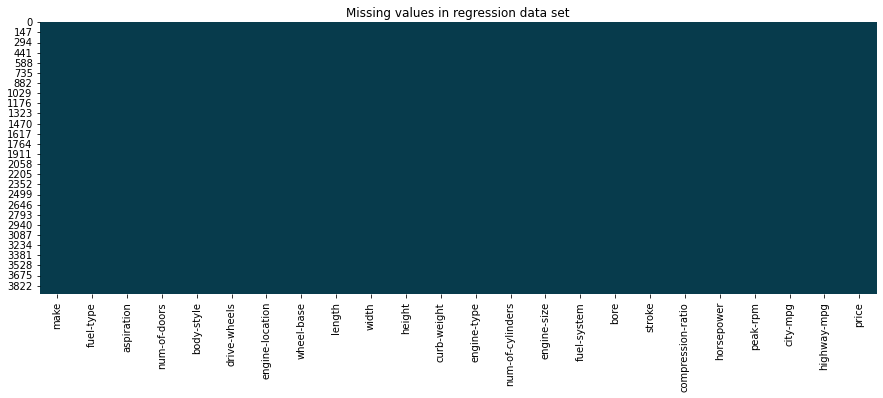

In [12]:
#checking for missing values:
print ("The total missing values in data",df.isnull().sum().sum())
#sum is 0 which indicates there are no misisng values in the training data.
#Feature engineering
f,(ax1) = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 5))
g1 = sns.heatmap(df.loc[:].isnull(), cmap = ['#073B4C', '#EF476F'], cbar = False, ax = ax1)
g1.set_title('Missing values in regression data set')
plt.draw()

In [18]:
# Check the columns types
df.dtypes

make                  object
fuel-type             object
aspiration            object
num-of-doors          object
body-style            object
drive-wheels          object
engine-location       object
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type           object
num-of-cylinders      object
engine-size            int64
fuel-system           object
bore                 float64
stroke               float64
compression-ratio    float64
horsepower           float64
peak-rpm             float64
city-mpg               int64
highway-mpg            int64
price                float64
dtype: object

In [19]:
#Korrelation
corr_matrix = df.corr()
corr_matrix["price"].sort_values(ascending = False)

price                1.000000
engine-size          0.843361
horsepower           0.817318
curb-weight          0.810686
width                0.783324
length               0.655096
bore                 0.574585
wheel-base           0.521926
stroke               0.038816
height               0.019256
compression-ratio   -0.004380
peak-rpm            -0.065014
highway-mpg         -0.692285
city-mpg            -0.715199
Name: price, dtype: float64

In [20]:
#creating 2 seperate dataframes for categorical and continuous features.
train_df_cat = pd.DataFrame()#training data frame with categorical features
train_df_cont = pd.DataFrame() #training data with continuous features
cat_list = []#list of categorical features
cont_list = []#list of continuous features

#populating the created data frames for categorical and continuous features
for each_column in df.columns:
    if df[each_column].dtype == 'float':
        cont_list.append(each_column)
cont_list.remove('price')
for each_column in df.columns:
    if df[each_column].dtype == 'object':
        cat_list.append(each_column)

for i in range(0,len(cat_list)):
    train_df_cat[i] = df[cat_list[i]]
train_df_cat.columns =cat_list
for i in range(0,len(cont_list)):
    train_df_cont[i] = df[cont_list[i]]
train_df_cont.columns =cont_list

In [22]:
train_df_cont

,wheel-base,length,width,height,bore,stroke,compression-ratio,horsepower,peak-rpm
0,91.300003,157.300003,63.799999,49.700001,3.15,3.100158,9.00000,85.898399,5400.000000
1,96.300003,173.997803,65.400002,51.400002,3.15,3.460000,7.00000,114.396294,5500.000000
2,97.199997,176.199997,65.500000,54.900002,3.27,3.520000,8.70000,90.000000,5500.000000
3,94.500000,169.000000,63.900002,53.972446,3.15,3.294734,9.40000,69.539200,5200.000000
4,114.199997,192.699997,69.745056,56.700001,3.46,3.583720,22.91404,116.000000,4250.000000
...,...,...,...,...,...,...,...,...,...
3939,95.699997,170.199997,65.400002,55.500000,3.19,3.400000,9.00000,82.313522,5013.523926
3940,102.900002,175.390259,66.500000,53.122231,3.31,3.580000,9.00000,86.000000,4150.000000
3941,95.699997,172.399994,66.500000,50.200001,3.03,3.070000,9.60000,116.000000,6000.000000
3942,96.300003,176.199997,63.599998,54.299999,3.05,3.670542,9.00000,82.000000,5900.000000


In [25]:
from sklearn.preprocessing import OneHotEncoder
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')
# Convert  attributes to string type columns
enc_df = pd.DataFrame(enc.fit_transform(train_df_cat[cat_list]).toarray())
df_preis = df['price']
df = train_df_cont.join(enc_df)
df

,wheel-base,length,width,height,bore,stroke,compression-ratio,horsepower,peak-rpm,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,91.300003,157.300003,63.799999,49.700001,3.15,3.100158,9.00000,85.898399,5400.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,96.300003,173.997803,65.400002,51.400002,3.15,3.460000,7.00000,114.396294,5500.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,97.199997,176.199997,65.500000,54.900002,3.27,3.520000,8.70000,90.000000,5500.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,94.500000,169.000000,63.900002,53.972446,3.15,3.294734,9.40000,69.539200,5200.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,114.199997,192.699997,69.745056,56.700001,3.46,3.583720,22.91404,116.000000,4250.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3939,95.699997,170.199997,65.400002,55.500000,3.19,3.400000,9.00000,82.313522,5013.523926,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3940,102.900002,175.390259,66.500000,53.122231,3.31,3.580000,9.00000,86.000000,4150.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3941,95.699997,172.399994,66.500000,50.200001,3.03,3.070000,9.60000,116.000000,6000.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3942,96.300003,176.199997,63.599998,54.299999,3.05,3.670542,9.00000,82.000000,5900.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
#Scaling
mm_scale = preprocessing.MinMaxScaler(feature_range = (-1, 1))
df = mm_scale.fit_transform(df) 

In [ ]:
#dr = df_preis.copy()
#df_preis = df_preis.astype(int)

In [27]:
median = df_preis.median()

In [28]:
#df_preis = dr.copy()
df_preis = df_preis.astype(int)
for index, value in df_preis.items():
    if df_preis[index] < median: #Median:
        df_preis[index] = 0
    else:
        df_preis[index] = 1 #tobereplaced
df_preis = df_preis.astype(int)
df_preis[df_preis!=0].count(),df_preis[df_preis == 0].count()

(1972, 1972)

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df,df_preis,test_size = 0.3,random_state = 42)

In [ ]:
# PCA

In [30]:
pca = PCA(n_components = 0.95)
X_train_reduced = pca.fit_transform(X_train)
pca.n_components_

35

In [31]:
# Test Data
pca = PCA(n_components = 0.95)
X_test_reduced = pca.fit_transform(X_test)
X_train_reduced.shape,X_test_reduced.shape

((2760, 35), (1184, 35))

In [32]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1 
d

35

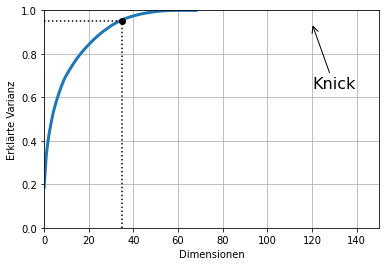

In [33]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 150, 0, 1])
plt.xlabel("Dimensionen")
plt.ylabel("Erklärte Varianz")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Knick", xy=(120, 0.94), xytext=(120, 0.64),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
#save_fig("explained_variance_plot")
plt.show()

In [34]:
X_train.shape,y_train.shape,X_train_reduced.shape

((2760, 69), (2760,), (2760, 35))

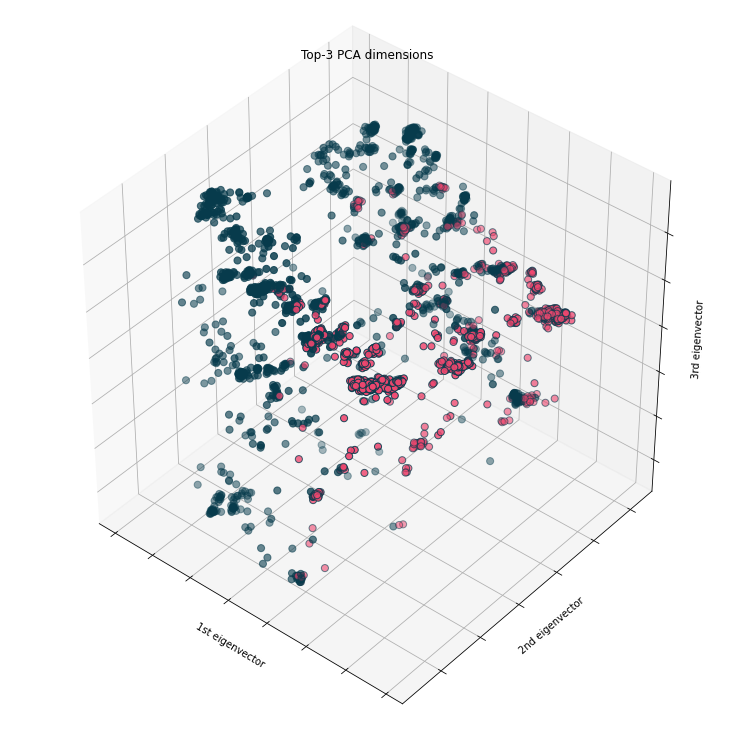

In [35]:
# Plot the result
owncmap = mc.ListedColormap(['#EF476F', '#FFD166', '#06D6A0', '#118AB2', '#F19143', '#073B4C'])
fig = plt.figure(1, figsize = (10, 10))
ax = Axes3D(fig, elev = -140, azim = 50)
ax.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], X_train_reduced[:, 2],      # first three dimensions of PCA
           c = y_train,                                               # color-coded by label
           cmap = owncmap, edgecolor = '#073B4C', s = 50)
ax.set_title("Top-3 PCA dimensions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])
plt.draw()

In [36]:
#print(pca.explained_variance_)                                    # absolute values
print(pca.explained_variance_ratio_)

[1.84707067e-01 1.50646634e-01 8.17062233e-02 5.75400280e-02
 5.01876809e-02 4.01530639e-02 3.34362474e-02 3.11146753e-02
 2.78227143e-02 2.52280533e-02 1.97398848e-02 1.71949898e-02
 1.67355008e-02 1.62192879e-02 1.54594880e-02 1.46169792e-02
 1.33527324e-02 1.25395922e-02 1.19327409e-02 1.11356366e-02
 1.08418320e-02 1.05143665e-02 1.04135690e-02 9.64837515e-03
 9.31090627e-03 8.68231773e-03 8.34136805e-03 7.78440211e-03
 7.40466242e-03 7.39258336e-03 7.29485934e-03 6.23280485e-03
 5.92639689e-03 5.21768207e-03 5.02338584e-03 4.87566108e-03
 4.54279646e-03 3.72280805e-03 3.35273875e-03 3.23219118e-03
 3.06940661e-03 2.77417866e-03 2.69437517e-03 2.57583100e-03
 2.12096415e-03 2.03871099e-03 1.82839602e-03 1.77076480e-03
 1.63479582e-03 1.41824763e-03 1.31749267e-03 1.12633438e-03
 9.91837851e-04 9.25447439e-04 6.53540362e-04 5.40055446e-04
 4.98900630e-04 4.31610332e-04 3.64182678e-04 3.64270460e-32
 6.08136308e-33 3.88959998e-33 3.55261357e-33 1.29994388e-33
 9.79978286e-34 9.799782

#Modeling

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import  cross_val_score,cross_val_predict

In [38]:
rf_params = {'criterion': 'entropy', 
             'max_depth': 15, 
             'n_estimators': 22984, 
             'min_samples_leaf': 3, 
             'min_samples_split': 9, 
             'max_leaf_nodes': 239, 
             'random_state': 22}

dt_params = {'criterion': 'entropy', 
             'max_depth': 35, 
             'min_samples_leaf': 4, 
             'min_samples_split': 23, 
             'max_leaf_nodes': 169}

svc_params = {'kernel': 'poly',
              'degree': 3,
              'coef0' : 1,
              'C': 5 }

knn_params = {'weights': 'distance', 
              'n_neighbors': 32}

lr_params = {'multi_class':'multinomial',
             'class_weight': None, 
             'solver': 'saga', 
             'max_iter':10000}

In [39]:
models =    {'dt':DecisionTreeClassifier(**dt_params),
               'rf':RandomForestClassifier(**rf_params), 
               'svc':SVC(**svc_params), 
               'kn':KNeighborsClassifier(**knn_params),  
               'lr':LogisticRegression(**lr_params)}

model_abrv = {'dt':'Decision Tree Classifier', 
             'rf':'Random Forest Classifier',
              'svc':'Support Vector Machines',
              'kn':'K-Nearest Neighbors', 
              'lr':'Logistic Regression'}

In [40]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14, model='clf', save=True):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a seaborn heatmap. 
    Saves confusion matrix file to jpg file."""
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, ax=ax, fmt="d", cmap=plt.cm.Oranges)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() 
    b += 0.5 
    t -= 0.5 
    plt.ylim(b, t) 
#    if save == True:
#        plt.savefig('tuned_' + model_abrv[model] + '_confusion_matrix.jpg')
    plt.show()

In [41]:
def model(clf, X_train=X_train_reduced, X_test=X_test_reduced, y_train=y_train, y_test=y_test, models=models, save=False, print_stat=True, inc_train=False, cv=False):
    """Trains models and outputs score metrics. Takes an identifier, list of models, and split dataset as inputs and has options for saving model, 
    printing confusion matrix and classification report and getting cross-validated 5 fold accuracy."""
    clf_model = models[clf]
    clf_model.fit(X_train, y_train)
    y_pred = clf_model.predict(X_test)
    if print_stat == True:
        clf_report = pd.DataFrame(classification_report(y_test,y_pred, output_dict=True)).T
#        clf_report.to_csv('tuned_' + model_abrv[clf] + '_classification_report.csv')
        print(model_abrv[clf])
        print('\nTest Stats\n', classification_report(y_test,y_pred))
        print_confusion_matrix(confusion_matrix(y_test, y_pred), unique_labels(y_test, y_pred), model=clf)
        if inc_train == True:
            print(model_abrv[clf])
            print('\nTrain Stats\n', classification_report(y_train,clf_model.predict(X_train)))
            print_confusion_matrix(confusion_matrix(y_train, clf_model.predict(X_train)), unique_labels(y_test, y_pred), model=clf)
    if cv == True:
        print(model_abrv[clf] + ' CV Accuracy:',  
              np.mean(cross_val_score(clf_model, X_train, y_train, cv=5, scoring='accuracy')))
    if save == True:
        return clf_model

#Evaluation

In [42]:
for key in models.keys():
    model(key, cv=True, print_stat=False)

Decision Tree Classifier CV Accuracy: 0.902536231884058
Random Forest Classifier CV Accuracy: 0.928623188405797
Support Vector Machines CV Accuracy: 0.9213768115942029
K-Nearest Neighbors CV Accuracy: 0.9090579710144928
Logistic Regression CV Accuracy: 0.9184782608695652


Decision Tree Classifier

Test Stats
               precision    recall  f1-score   support

           0       0.79      0.74      0.76       580
           1       0.76      0.81      0.78       604

    accuracy                           0.77      1184
   macro avg       0.78      0.77      0.77      1184
weighted avg       0.78      0.77      0.77      1184



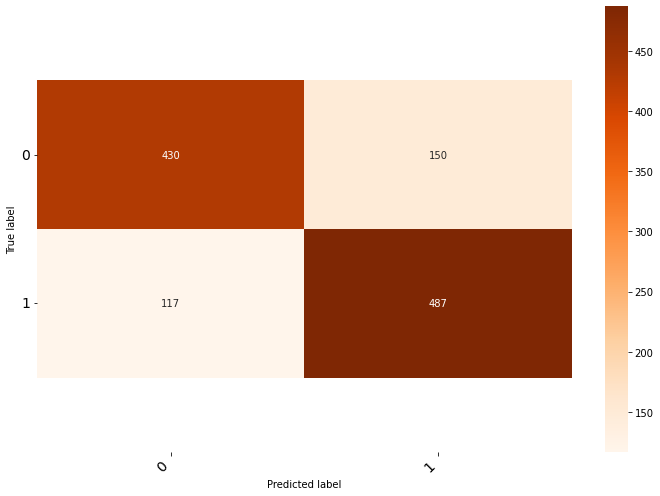

Decision Tree Classifier

Train Stats
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      1392
           1       0.95      0.97      0.96      1368

    accuracy                           0.96      2760
   macro avg       0.96      0.96      0.96      2760
weighted avg       0.96      0.96      0.96      2760



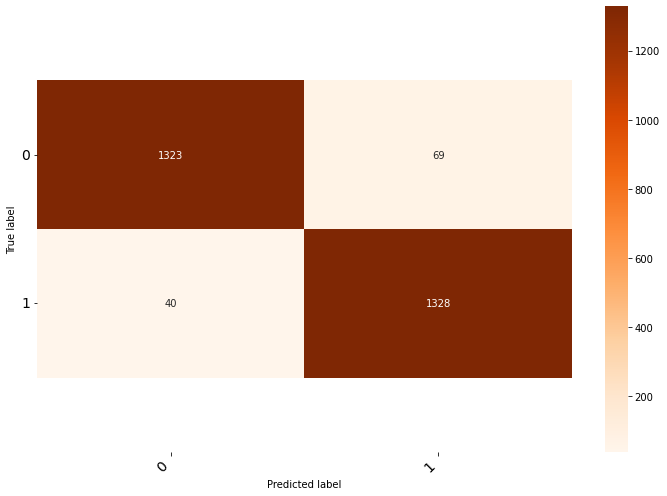

Random Forest Classifier

Test Stats
               precision    recall  f1-score   support

           0       0.89      0.84      0.86       580
           1       0.85      0.90      0.88       604

    accuracy                           0.87      1184
   macro avg       0.87      0.87      0.87      1184
weighted avg       0.87      0.87      0.87      1184



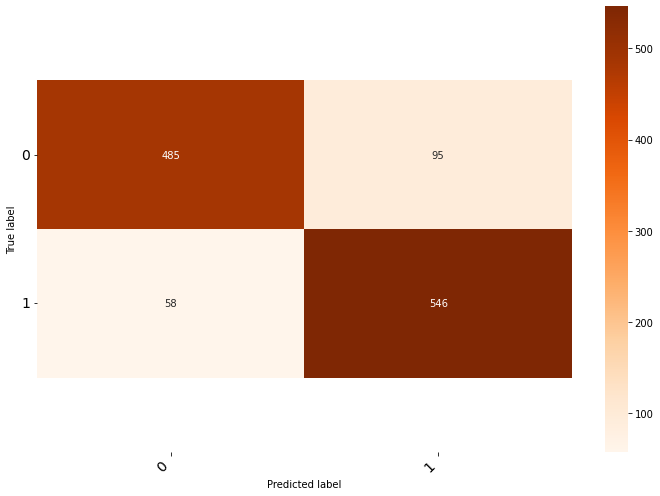

Random Forest Classifier

Train Stats
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1392
           1       0.98      0.98      0.98      1368

    accuracy                           0.98      2760
   macro avg       0.98      0.98      0.98      2760
weighted avg       0.98      0.98      0.98      2760



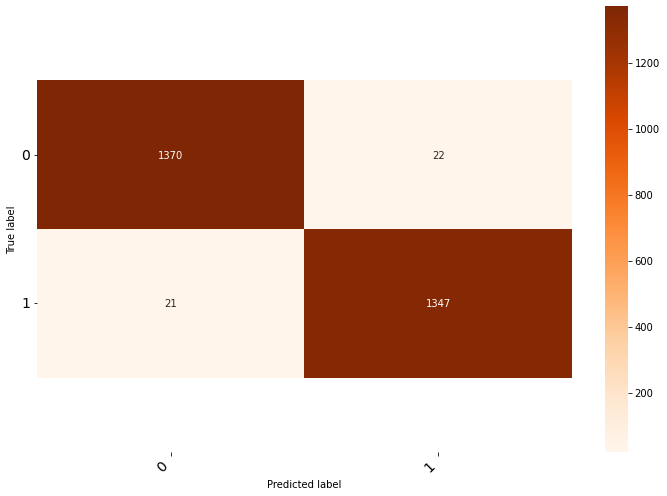

Support Vector Machines

Test Stats
               precision    recall  f1-score   support

           0       0.80      0.75      0.77       580
           1       0.77      0.82      0.80       604

    accuracy                           0.79      1184
   macro avg       0.79      0.79      0.79      1184
weighted avg       0.79      0.79      0.79      1184



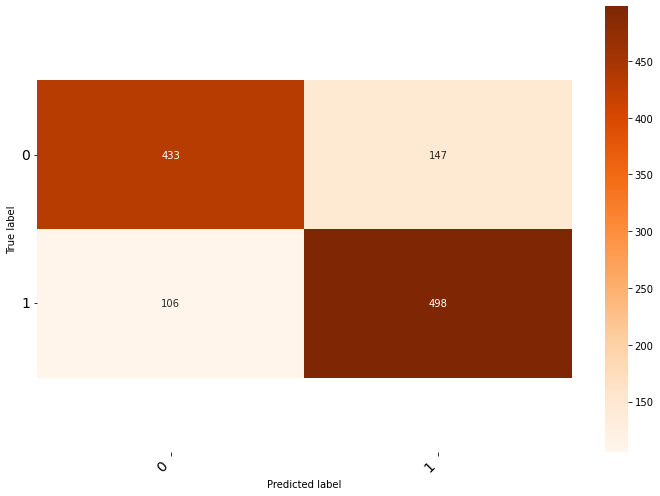

Support Vector Machines

Train Stats
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      1392
           1       0.98      0.97      0.98      1368

    accuracy                           0.98      2760
   macro avg       0.98      0.98      0.98      2760
weighted avg       0.98      0.98      0.98      2760



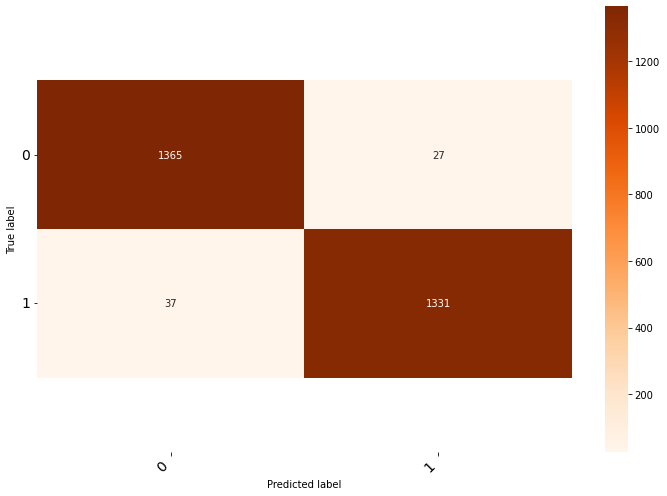

K-Nearest Neighbors

Test Stats
               precision    recall  f1-score   support

           0       0.82      0.87      0.84       580
           1       0.87      0.81      0.84       604

    accuracy                           0.84      1184
   macro avg       0.84      0.84      0.84      1184
weighted avg       0.84      0.84      0.84      1184



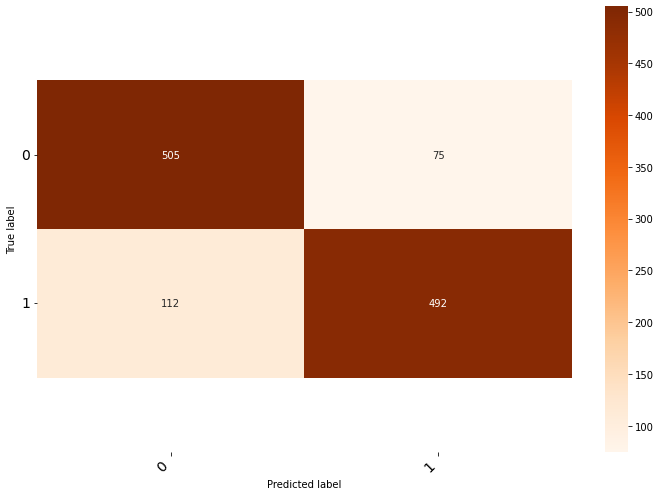

K-Nearest Neighbors

Train Stats
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1392
           1       1.00      1.00      1.00      1368

    accuracy                           1.00      2760
   macro avg       1.00      1.00      1.00      2760
weighted avg       1.00      1.00      1.00      2760



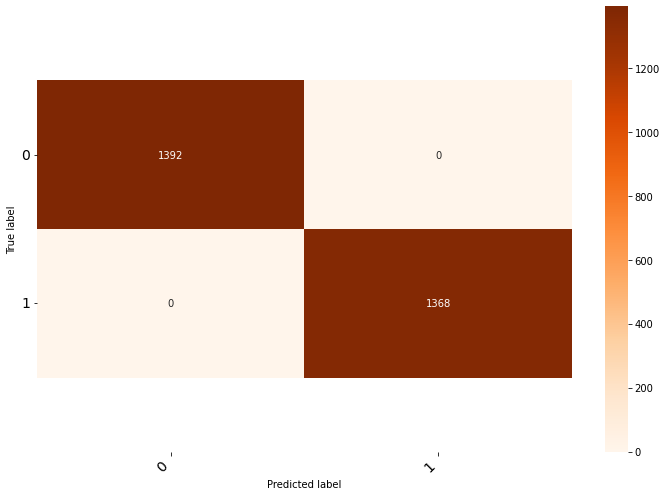

Logistic Regression

Test Stats
               precision    recall  f1-score   support

           0       0.82      0.79      0.81       580
           1       0.81      0.83      0.82       604

    accuracy                           0.81      1184
   macro avg       0.81      0.81      0.81      1184
weighted avg       0.81      0.81      0.81      1184



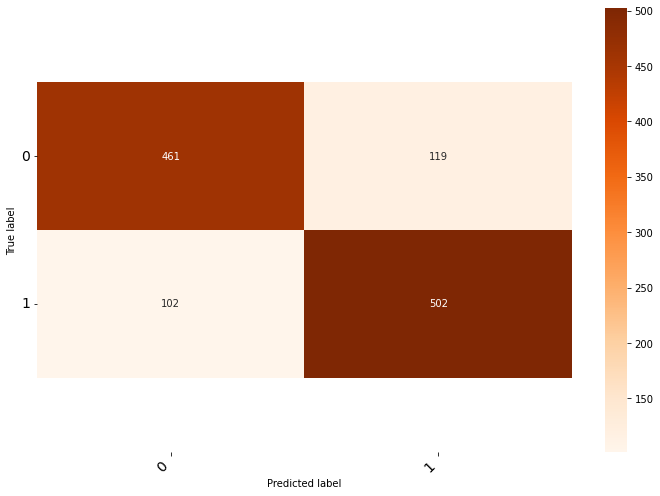

Logistic Regression

Train Stats
               precision    recall  f1-score   support

           0       0.92      0.93      0.92      1392
           1       0.93      0.91      0.92      1368

    accuracy                           0.92      2760
   macro avg       0.92      0.92      0.92      2760
weighted avg       0.92      0.92      0.92      2760



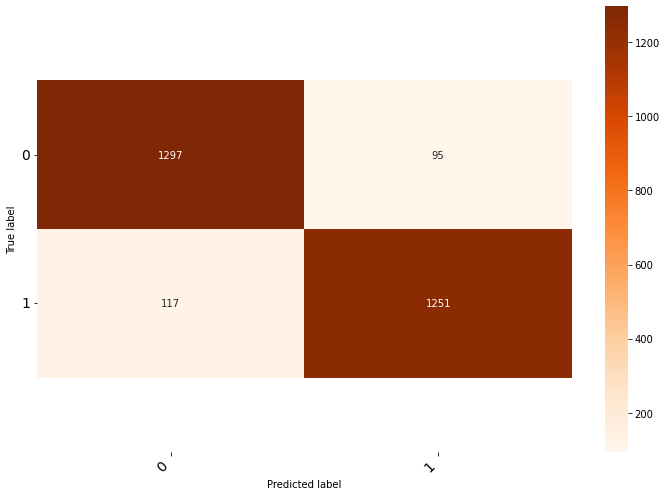

In [43]:
for key in models.keys():
    model(key, inc_train=True)

#Logistische Regression

In [69]:
log_reg = LogisticRegression(multi_class = 'ovr',
             class_weight = None, 
             solver= 'saga', 
             max_iter = 10000)

In [70]:
log_reg.fit(X_train_reduced,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [71]:
y_cla_pred = log_reg.predict(X_test_reduced)
log_reg.score(X_test_reduced, y_test)# Die Genauigkeit für den Testdatensatz

0.8201013513513513

In [72]:
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters = d)),
    ("log_reg", LogisticRegression(multi_class = 'ovr',
             class_weight = None, 
             solver= 'saga', 
             max_iter = 10000)),
])

In [75]:
pipeline.fit(X_train,y_train)
pipeline.score(X_test, y_test)# Die Genauigkeit für den Testdatensatz

0.84375

In [49]:
probs = log_reg.predict_proba(X_test_reduced)
probs = probs[:,1]

In [50]:
y_probas_log_reg = cross_val_predict(log_reg,X_train_reduced, y_train,cv=3, method="predict_proba" )
probs_lr = y_probas_log_reg[:,1]

In [51]:
fpr, tpr, thresholds = roc_curve(y_train, probs_lr)

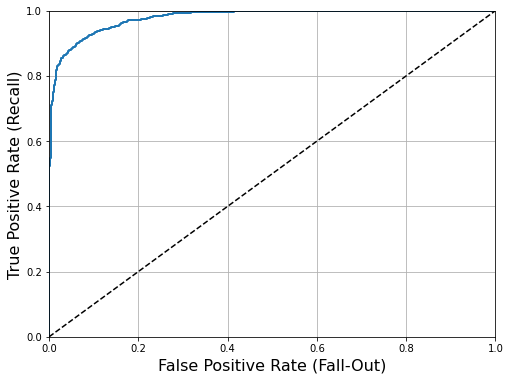

In [52]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.show()

# Neuronale Netze

In [53]:
from keras.models import Sequential
import keras
from keras.layers import Dense
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D,SpatialDropout1D
from keras.models import Model
from tensorflow.keras import optimizers as optimizers
from sklearn.metrics import classification_report,confusion_matrix

In [54]:
X_train = X_train_reduced.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test_reduced.astype('float32')
y_test = y_test.astype('float32')

In [55]:
x_traincnn = np.expand_dims(X_train, axis=(2))
x_testcnn = np.expand_dims(X_test, axis=(2))
x_traincnn.shape,x_testcnn.shape

((2760, 35, 1), (1184, 35, 1))

In [58]:
model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(35,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(2)) # auf 2 setzen und neu trainieren
model.add(Activation('softmax'))
opt = optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [59]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 35, 128)           768       
_________________________________________________________________
activation_3 (Activation)    (None, 35, 128)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 35, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 128)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4, 128)            82048     
_________________________________________________________________
activation_4 (Activation)    (None, 4, 128)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 128)           

In [60]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=["acc"])

In [61]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=100, validation_data=(x_testcnn, y_test))

Epoch 1/100
173/173 [==============================] - 3s 8ms/step - loss: 0.6231 - acc: 0.6986 - val_loss: 0.6028 - val_acc: 0.7432
Epoch 2/100
173/173 [==============================] - 1s 7ms/step - loss: 0.5378 - acc: 0.7670 - val_loss: 0.5436 - val_acc: 0.7711
Epoch 3/100
173/173 [==============================] - 1s 7ms/step - loss: 0.4758 - acc: 0.7899 - val_loss: 0.5098 - val_acc: 0.7796
Epoch 4/100
173/173 [==============================] - 1s 7ms/step - loss: 0.4339 - acc: 0.8138 - val_loss: 0.4872 - val_acc: 0.7829
Epoch 5/100
173/173 [==============================] - 1s 7ms/step - loss: 0.4020 - acc: 0.8232 - val_loss: 0.4670 - val_acc: 0.7931
Epoch 6/100
173/173 [==============================] - 1s 7ms/step - loss: 0.3780 - acc: 0.8322 - val_loss: 0.4549 - val_acc: 0.8007
Epoch 7/100
173/173 [==============================] - 1s 7ms/step - loss: 0.3616 - acc: 0.8377 - val_loss: 0.4473 - val_acc: 0.7948
Epoch 8/100
173/173 [==============================] - 1s 8ms/step - 

In [62]:
loss, acc = model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

37/37 [==============================] - 0s 3ms/step - loss: 0.4870 - acc: 0.8024
Restored model, accuracy: 80.24%


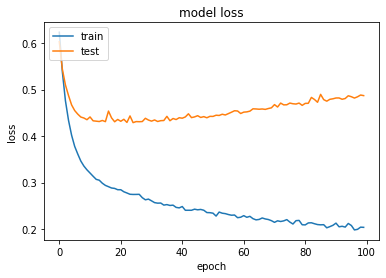

In [63]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

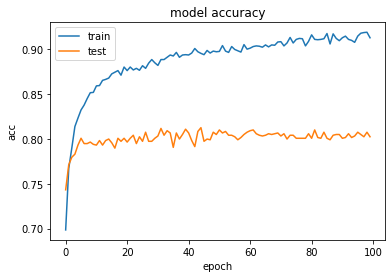

In [64]:
plt.plot(cnnhistory.history['acc'])
plt.plot(cnnhistory.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [65]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix (Keras ResNet - Modell)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
  #      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

 #   print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

44/44 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

         0.0       0.95      0.88      0.91      1392
         1.0       0.89      0.95      0.92      1368

    accuracy                           0.92      2760
   macro avg       0.92      0.92      0.92      2760
weighted avg       0.92      0.92      0.92      2760

Confusion matrix, without normalization


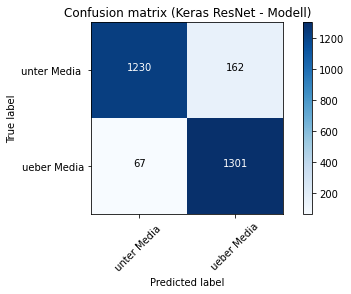

In [66]:
Preis = {0:'unter Media ', 1:'ueber Media'} 
class_names = [Preis[ind] for ind in range(len(Preis))]
y_pred_train = model.predict(x_traincnn, batch_size=64, verbose=1)
y_pred_b = np.argmax(y_pred_train, axis=1)

print(classification_report(y_train, y_pred_b))
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(confusion_matrix(y_train, y_pred_b), classes=class_names)
plt.show()

19/19 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

         0.0       0.80      0.79      0.80       580
         1.0       0.80      0.81      0.81       604

    accuracy                           0.80      1184
   macro avg       0.80      0.80      0.80      1184
weighted avg       0.80      0.80      0.80      1184

Confusion matrix, without normalization


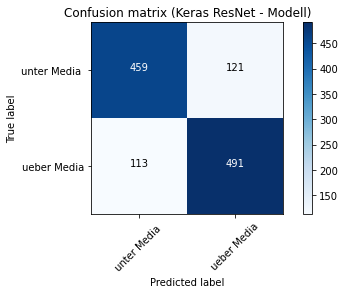

In [67]:
y_pred_test = model.predict(x_testcnn, batch_size=64, verbose=1)
y_pred_t = np.argmax(y_pred_test, axis=1)

print(classification_report(y_test, y_pred_t))
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, y_pred_t), classes=class_names)
plt.show()

In [ ]:
#save